## Importing Libraries

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import csv
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
import matplotlib.cm as cm
import time
from warnings import filterwarnings
filterwarnings(action='ignore')
random_seed = int(time.time())

## Loading Dataset

In [65]:
path = kagglehub.dataset_download("bhavikbb/password-strength-classifier-dataset")
csv_file = os.path.join(path, 'data.csv')

passwords = []
strengths = []

with open(csv_file, 'r', newline='', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader) 
    for row in csv_reader:
        if len(row) == 2:
            passwords.append(row[0])
            strengths.append(int(row[1]))

df = pd.DataFrame({'password': passwords, 'strength': strengths})
df = df.sample(n=50000, random_state=random_seed) #We chose 10k samples so we can compute each model in reasonable time.

print(df['strength'].value_counts()) # Dataset is not balanced - strength value "1" is dominating which could lead to overfitting.

# Balance the dataset by downsampling the majority classes
min_count = df['strength'].value_counts().min()

# Sample min_count passwords from each class
df = df.groupby('strength').apply(lambda x: x.sample(n=min_count, random_state=random_seed)).reset_index(drop=True)

# Verify the class distribution
print(df['strength'].value_counts())

print(df.head())
print(df.shape)

strength
1    37127
0     6673
2     6200
Name: count, dtype: int64
strength
0    6200
1    6200
2    6200
Name: count, dtype: int64
  password  strength
0   maxi87         0
1   21juni         0
2   jpgm29         0
3  bbwdvt4         0
4   fff123         0
(18600, 2)


## Description

In [66]:
print(df.describe(include='all'))

       password      strength
count     18600  18600.000000
unique    18600           NaN
top      maxi87           NaN
freq          1           NaN
mean        NaN      1.000000
std         NaN      0.816519
min         NaN      0.000000
25%         NaN      0.000000
50%         NaN      1.000000
75%         NaN      2.000000
max         NaN      2.000000


## Finding Null Values

In [67]:
print(df.isna().sum())

password    0
strength    0
dtype: int64


## Feature Engineering

In [68]:
def calculate_entropy(password):
    password = password.lower()
    password_length = len(password)
    entropy = 0
    for char in set(password):
        prob = password.count(char) / password_length
        entropy -= prob * np.log2(prob)
    return entropy

def calculate_diversity(password):
    lower = sum(1 for c in password if c.islower())
    upper = sum(1 for c in password if c.isupper())
    digits = sum(1 for c in password if c.isdigit())
    specials = sum(1 for c in password if not c.isalnum())
    return lower, upper, digits, specials

def contains_sequential(password):
    for seq in ["123", "234", "345", "456", "567", "678", "789", "qwerty", "asdf", "zxcv", "1q2w3e"]:
        if seq in password.lower():
            return 1
    return 0

def calculate_length(password):
    return len(password)

# Apply feature engineering functions to the dataset
df['length'] = df['password'].apply(calculate_length)
df['entropy'] = df['password'].apply(calculate_entropy)
df['lowercase'], df['uppercase'], df['digits'], df['specials'] = zip(*df['password'].apply(calculate_diversity))
df['sequential'] = df['password'].apply(contains_sequential)

# New dataframe including the new features
print(df.head(10))

  password  strength  length   entropy  lowercase  uppercase  digits  \
0   maxi87         0       6  2.584963          4          0       2   
1   21juni         0       6  2.584963          4          0       2   
2   jpgm29         0       6  2.584963          4          0       2   
3  bbwdvt4         0       7  2.521641          6          0       1   
4   fff123         0       6  1.792481          3          0       3   
5  chitra1         0       7  2.807355          6          0       1   
6   xvbv62         0       6  2.251629          4          0       2   
7   hvyd12         0       6  2.584963          4          0       2   
8  ojeda11         0       7  2.521641          5          0       2   
9  l000000         0       7  0.591673          1          0       6   

   specials  sequential  
0         0           0  
1         0           0  
2         0           0  
3         0           0  
4         0           1  
5         0           0  
6         0           0  

## Data Analysis

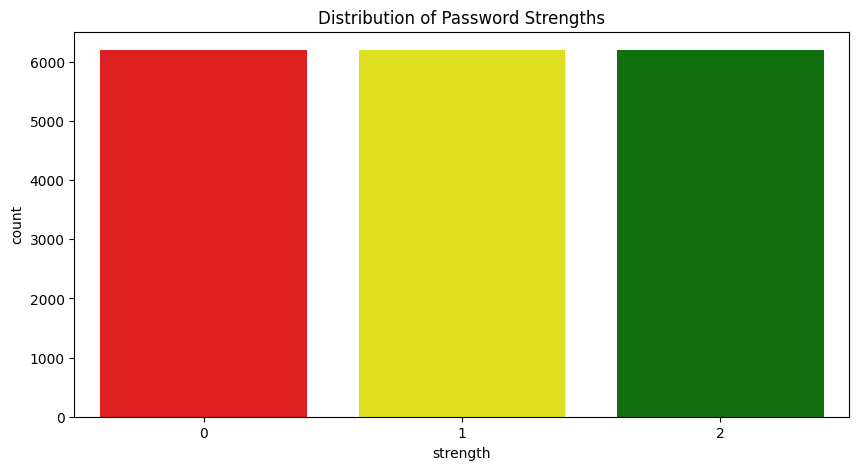

In [69]:
plt.figure(figsize=(10,5))
sns.countplot(x='strength', data=df, palette={"0":"red", "1" :"yellow", "2": "green"})
plt.title('Distribution of Password Strengths')
plt.show()

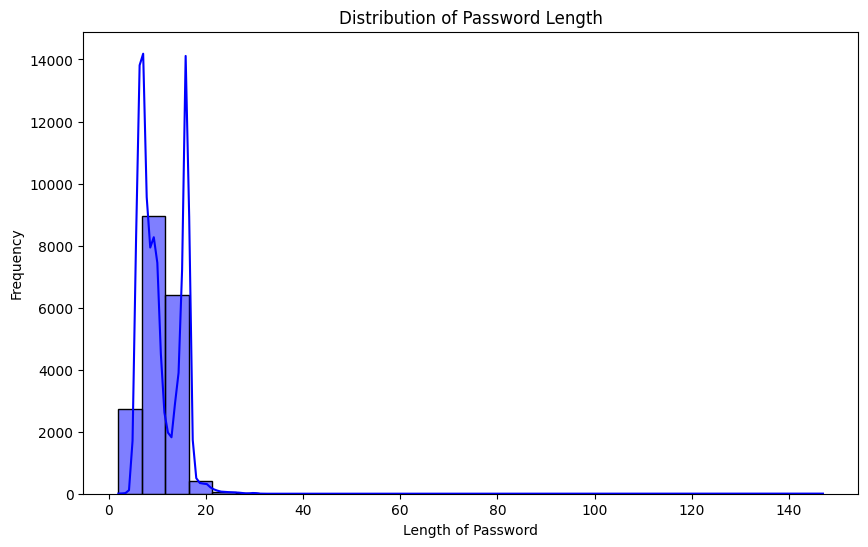

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(df['length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Password Length')
plt.xlabel('Length of Password')
plt.ylabel('Frequency')
plt.show()

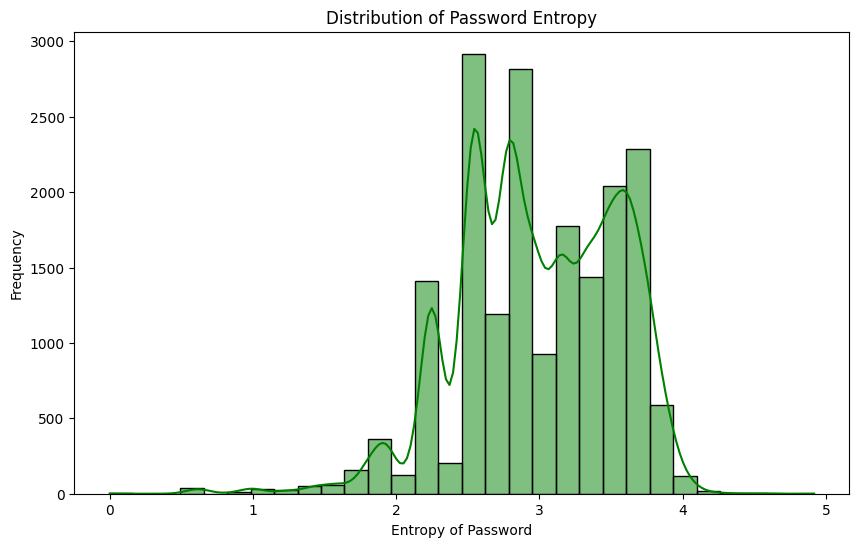

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(df['entropy'], bins=30, kde=True, color='green')
plt.title('Distribution of Password Entropy')
plt.xlabel('Entropy of Password')
plt.ylabel('Frequency')
plt.show()

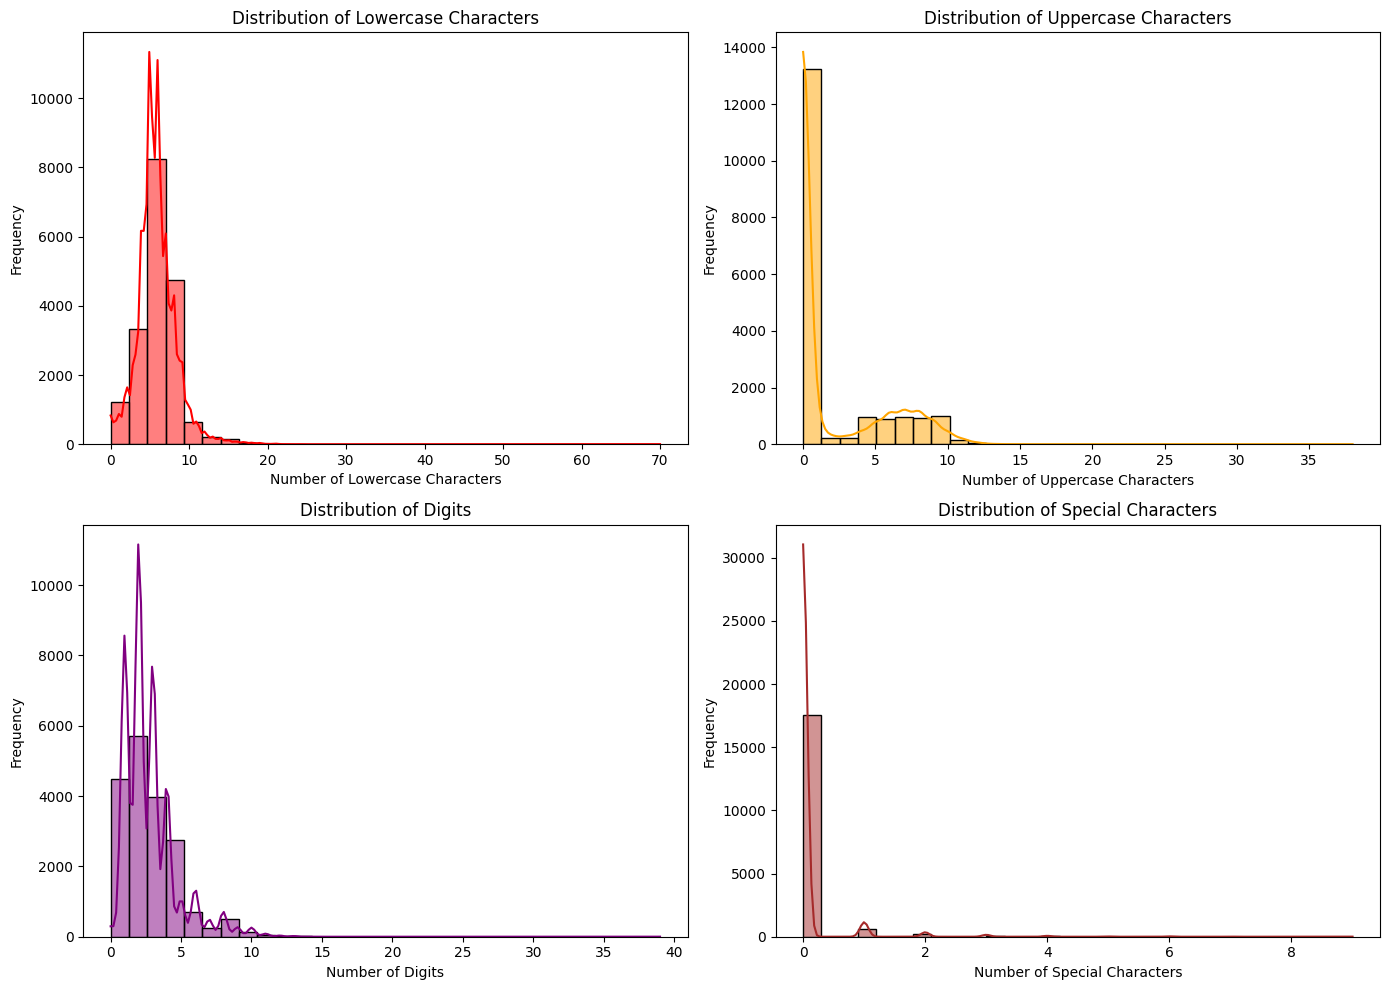

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Lowercase characters
sns.histplot(df['lowercase'], bins=30, kde=True, color='red', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Lowercase Characters')
axes[0, 0].set_xlabel('Number of Lowercase Characters')
axes[0, 0].set_ylabel('Frequency')

# Uppercase characters
sns.histplot(df['uppercase'], bins=30, kde=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Uppercase Characters')
axes[0, 1].set_xlabel('Number of Uppercase Characters')
axes[0, 1].set_ylabel('Frequency')

# Digits
sns.histplot(df['digits'], bins=30, kde=True, color='purple', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Digits')
axes[1, 0].set_xlabel('Number of Digits')
axes[1, 0].set_ylabel('Frequency')

# Specials
sns.histplot(df['specials'], bins=30, kde=True, color='brown', ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Special Characters')
axes[1, 1].set_xlabel('Number of Special Characters')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

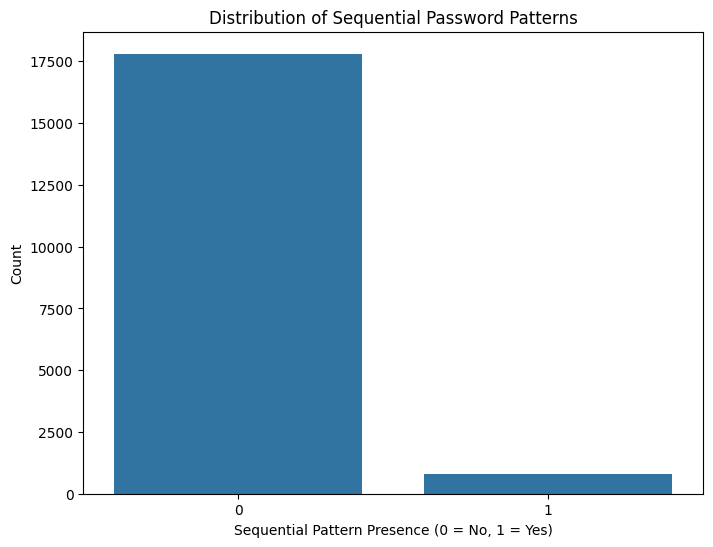

In [73]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['sequential'])
plt.title('Distribution of Sequential Password Patterns')
plt.xlabel('Sequential Pattern Presence (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

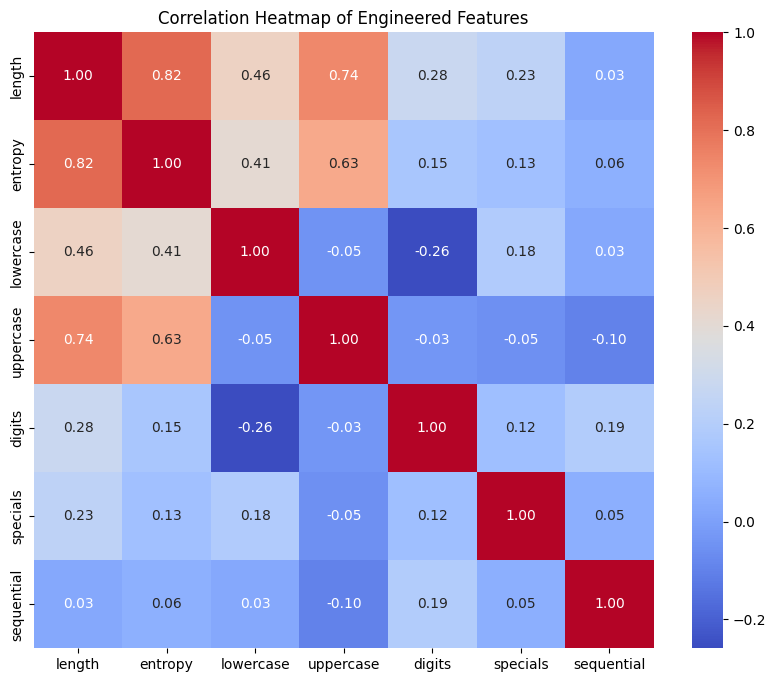

In [74]:
plt.figure(figsize=(10, 8))
corr = df[['length', 'entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Engineered Features')
plt.show()

## Prepare the engineered features

In [75]:
X_engineered = df[['length', 'entropy', 'lowercase', 'uppercase', 'digits', 'specials', 'sequential']]
y = df['strength']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_engineered, y, test_size=0.3, random_state=random_seed,shuffle=True)

In [76]:
## Function to evaluate model

In [77]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

## Model Training

In [78]:
# KNN
print("\nKNN Classifier:")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
evaluate_model(knn_model, X_test, y_test)


KNN Classifier:
Accuracy Score: 0.9991039426523297

Confusion Matrix:
[[1825    0    0]
 [   2 1862    2]
 [   0    1 1888]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1825
           1       1.00      1.00      1.00      1866
           2       1.00      1.00      1.00      1889

    accuracy                           1.00      5580
   macro avg       1.00      1.00      1.00      5580
weighted avg       1.00      1.00      1.00      5580



In [79]:
print("\nSVM Classifier:")
svm_model = SVC()
svm_model.fit(X_train, y_train)
evaluate_model(svm_model, X_test, y_test)


SVM Classifier:
Accuracy Score: 0.9992831541218637

Confusion Matrix:
[[1825    0    0]
 [   1 1862    3]
 [   0    0 1889]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1825
           1       1.00      1.00      1.00      1866
           2       1.00      1.00      1.00      1889

    accuracy                           1.00      5580
   macro avg       1.00      1.00      1.00      5580
weighted avg       1.00      1.00      1.00      5580



In [80]:
# Logistic Regression
print("\nLogistic Regression:")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
evaluate_model(lr_model, X_test, y_test)


Logistic Regression:
Accuracy Score: 0.9996415770609319

Confusion Matrix:
[[1825    0    0]
 [   2 1864    0]
 [   0    0 1889]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1825
           1       1.00      1.00      1.00      1866
           2       1.00      1.00      1.00      1889

    accuracy                           1.00      5580
   macro avg       1.00      1.00      1.00      5580
weighted avg       1.00      1.00      1.00      5580



In [81]:
# Random Forest
print("\nRandom Forest Classifier:")
rf_model = RandomForestClassifier(random_state=random_seed)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test)


Random Forest Classifier:
Accuracy Score: 1.0

Confusion Matrix:
[[1825    0    0]
 [   0 1866    0]
 [   0    0 1889]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1825
           1       1.00      1.00      1.00      1866
           2       1.00      1.00      1.00      1889

    accuracy                           1.00      5580
   macro avg       1.00      1.00      1.00      5580
weighted avg       1.00      1.00      1.00      5580



## Model Comparison

In [82]:
models = [
    ('KNN', knn_model),
    ('SVM', svm_model),
    ('Logistic Regression', lr_model),
    ('Random Forest', rf_model)
]

results = []
for name, model in models:
    score = accuracy_score(y_test, model.predict(X_test))
    results.append((name, score))



results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])
results_df = results_df.sort_values('Accuracy', ascending=False).set_index('Accuracy')
print("\nModel Comparison:")
print(results_df)


Model Comparison:
                        Model
Accuracy                     
1.000000        Random Forest
0.999642  Logistic Regression
0.999283                  SVM
0.999104                  KNN


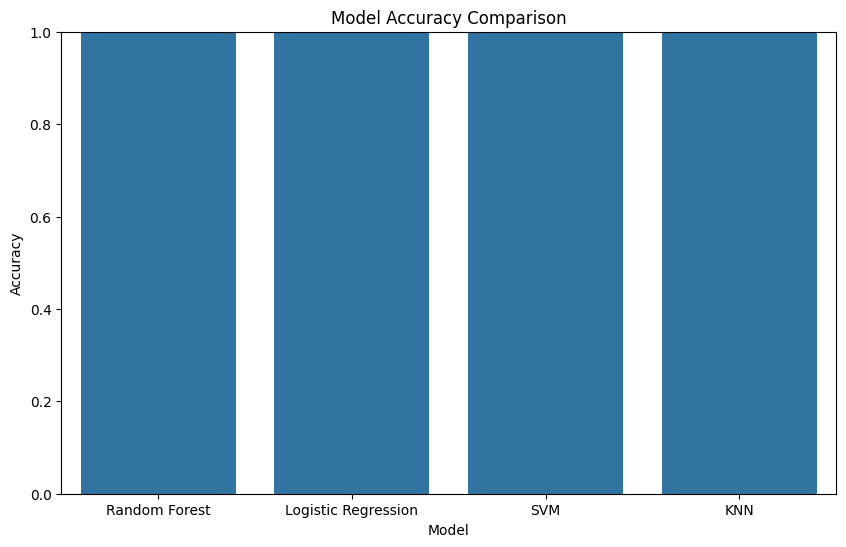

In [83]:
# Visualizing Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df.reset_index())
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

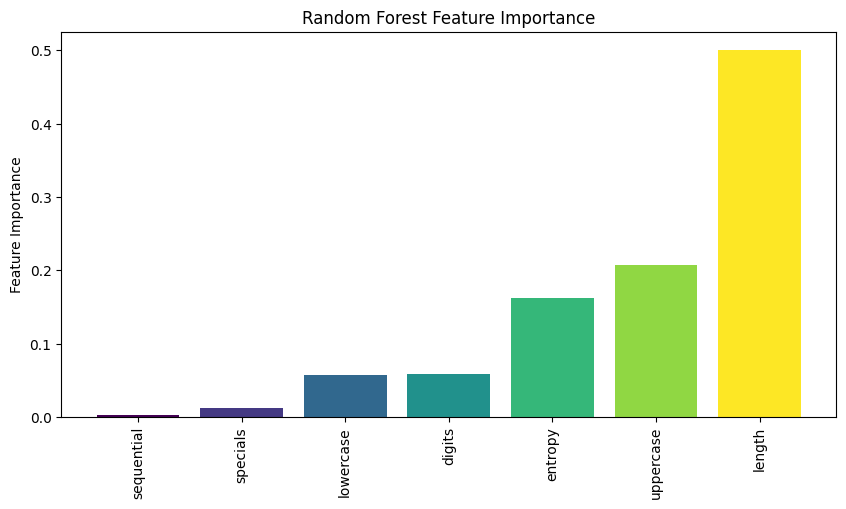

In [84]:
# Get the feature importances and sort them
rf_importances = rf_model.feature_importances_
features = X_engineered.columns
sorted_indices = np.argsort(rf_importances)[::-1]  # Sort in descending order

# Sort features and their importances
sorted_features = np.array(features)[sorted_indices]
sorted_importances = rf_importances[sorted_indices]

# Create a colormap for the bars
colors = cm.viridis(np.linspace(0, 1, len(sorted_importances)))

# Plot the sorted feature importances, with the graph standing up
plt.figure(figsize=(10, 5))
plt.bar(sorted_features[::-1], sorted_importances[::-1], color=colors)
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

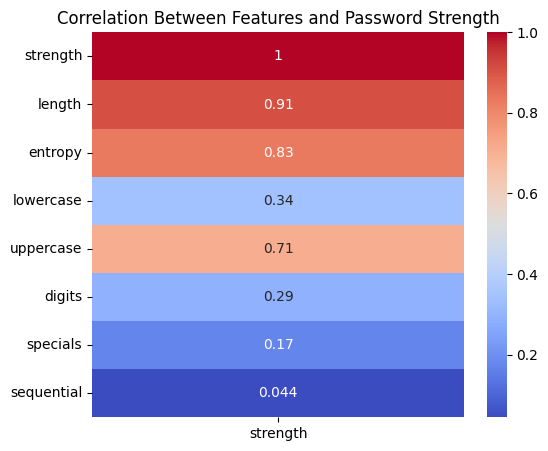

In [85]:

corr = df.corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr[['strength']], annot=True, cmap='coolwarm')
plt.title('Correlation Between Features and Password Strength')
plt.show()
